In [16]:
%load_ext autoreload
%autoreload 2

from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils

# ctapipe modules
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *
from ctapipe.io.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
from lstchain.calib.camera.r0 import LSTR0Corrections

r0calib = LSTR0Corrections(
    pedestal_path="../../cta-lstchain-extra/calib/camera/pedestal_file_run446_0000.fits",
    r1_sample_start=2,r1_sample_end=38)



# flat field run with interleaved flatfield and pedestal events (for the moment to big for cta-lstchain-extra)
run = 472


#datadir = '/ctadata/franca/LST' 
datadir = '/fefs/onsite/data/20190527'
file = f'{datadir}/LST-1.1.Run00{run}.0000.fits.fz'


reader = event_source(file, max_events=None)
print(f"\n Read {len(reader.multi_file)} total events  in files\n")
print(f"{reader.file_list} ")

channel=['HG','LG']

# use the tool to write calibration coefficients
from lstchain.tools.calc_camera_calibration import CalibrationHDF5Writer

tel_id=0 # LST1 for the moment


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

 Read 53004 total events  in files

['/ctadata/franca/LST/LST-1.1.Run00472.0000.fits.fz', '/ctadata/franca/LST/LST-1.2.Run00472.0000.fits.fz', '/ctadata/franca/LST/LST-1.3.Run00472.0000.fits.fz', '/ctadata/franca/LST/LST-1.4.Run00472.0000.fits.fz'] 


In [4]:
# read first flatfield event

for i, event in enumerate(reader): 
    # calibrate r0 --> r1        
    r0calib.calibrate(event)

    # select only flatfield events    
    if event.r0.tel[0].trigger_type == 32:        
        continue
           
    
    break
        
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[0].trigger_type}")
        

read event id: 2, trigger 1


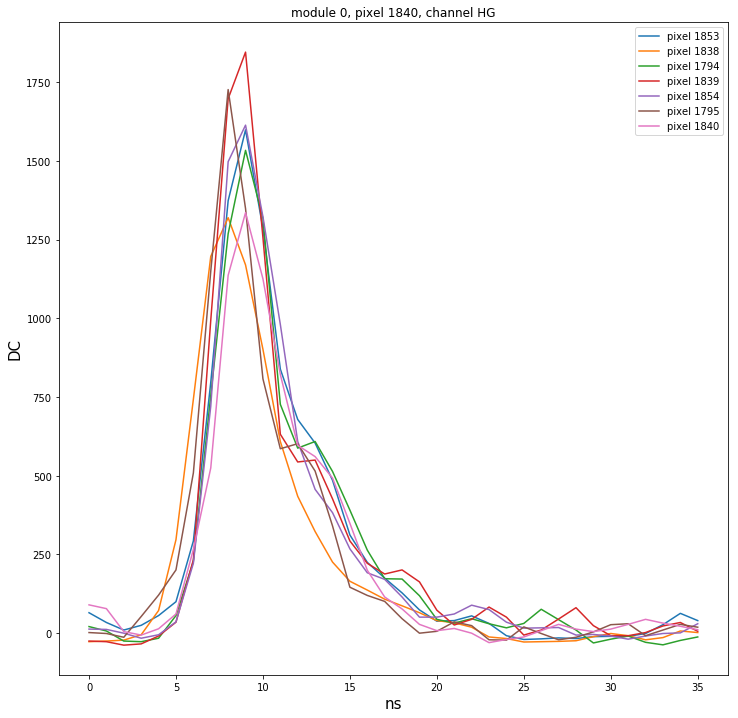

In [5]:
# plot R1 waveform of module [module]
def view_waveform(chan=0, pix_id=6,i=0):
    waveform = event.r1.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f'pixel {pix_id}')
  
    plt.title(f"module {module}, pixel {pix_id}, channel {channel[chan]}",)
    max_now=waveform[chan, pix_id].max()
    min_now=waveform[chan, pix_id].min()


    plt.legend()
    plt.ylabel('DC',fontsize=15) 
    plt.xlabel('ns',fontsize=15)
    

# module number    
module=0
# channel
chan=0
# ids of pixel in module
pixels_mod=event.lst.tel[0].svc.pixel_ids[module*7:module*7+7]
 
fig = plt.figure(num=0,figsize=(12,12))     

for i,pix  in enumerate(pixels_mod):    

    view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

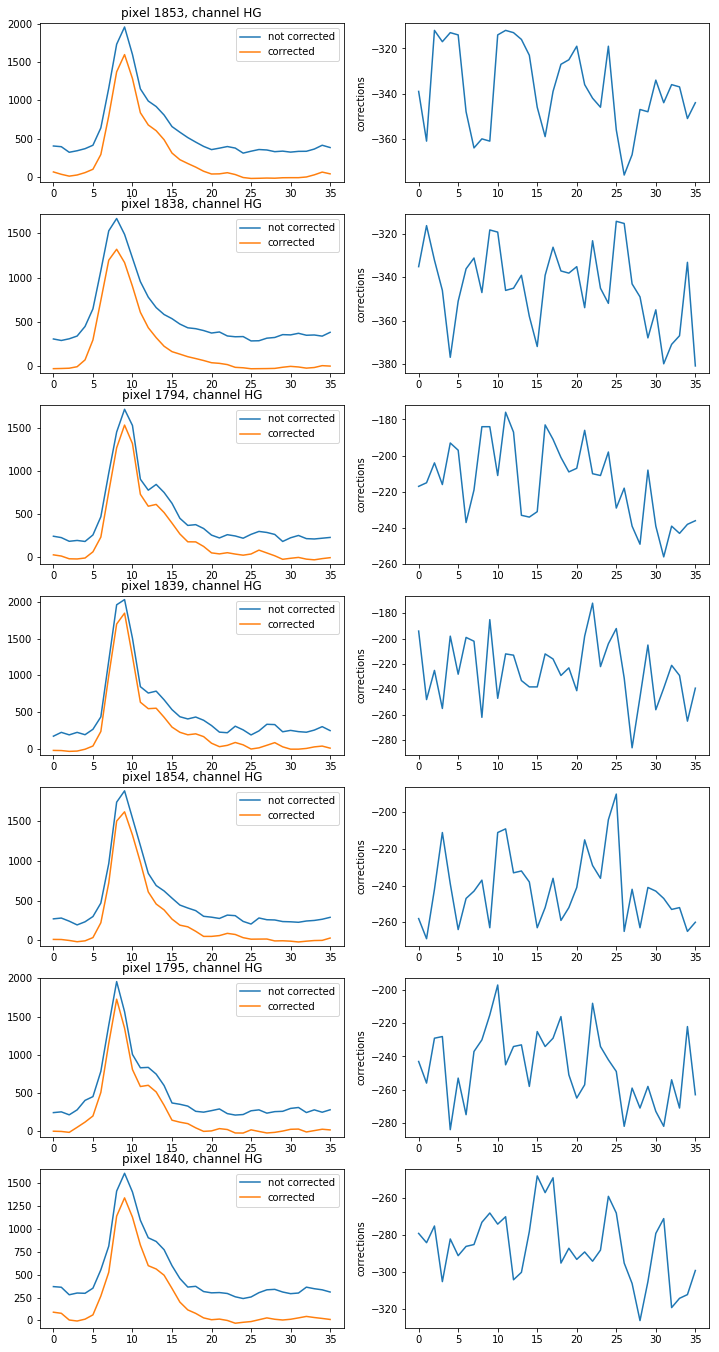

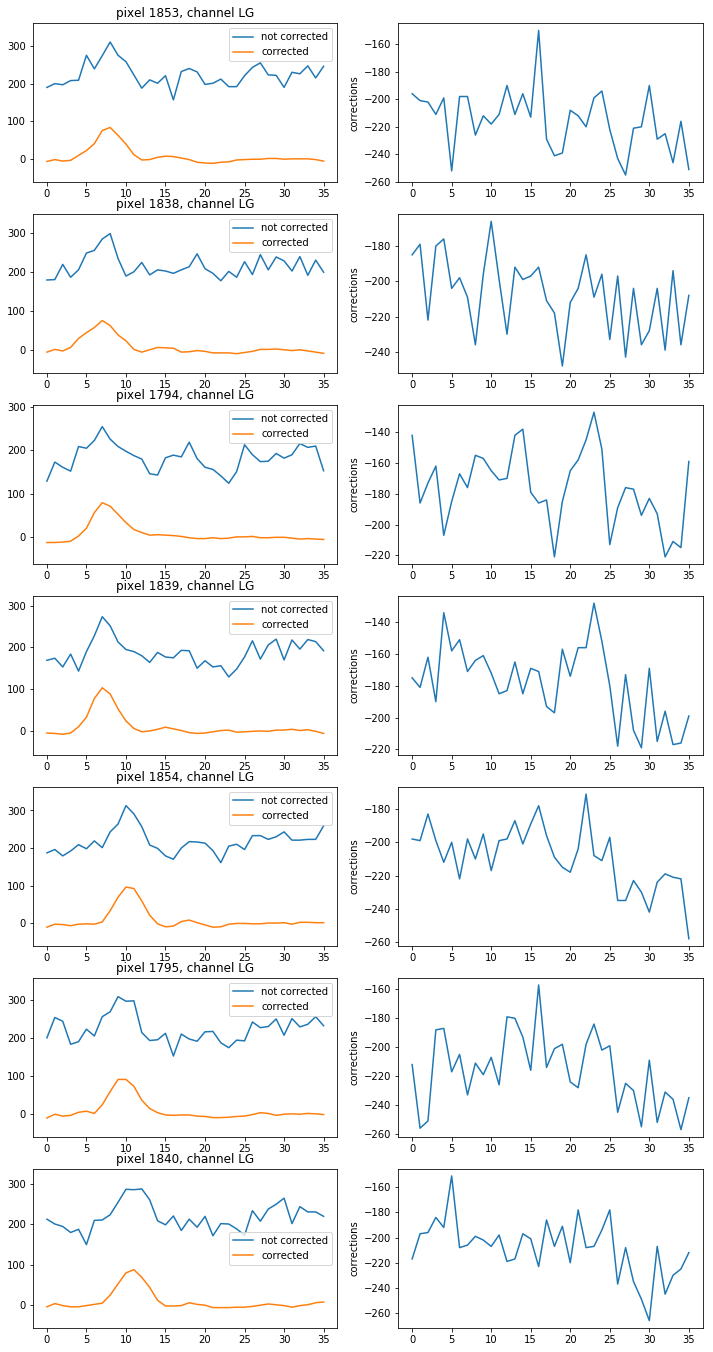

In [6]:
# plot effect of low-level calibration on module 
def view_waveform(chan=0, pix_id=6,i=0):

    plot_id=i*2+1
    plt.subplot(7,2,plot_id)
 
    plt.plot(event.r0.tel[tel_id].waveform[chan, pix_id,2:38], label='not corrected')
    plt.plot(event.r1.tel[tel_id].waveform[chan, pix_id], label='corrected') 
    
    plt.title(f"pixel {pix_id}, channel {channel[chan]}",)
    
    mymax=max(newwaveform[chan, pix_id].max(),oldwaveform[chan, pix_id].max()) + 50
    mymin=min(newwaveform[chan, pix_id].min(),oldwaveform[chan, pix_id].min()) - 50
    
    plt.ylim(mymin,mymax)
    plt.legend()
    plot_id=(i*2)+2
    
    plt.subplot(7,2,plot_id)
    plt.plot(newwaveform[chan, pix_id]-oldwaveform[chan, pix_id])
    plt.ylabel('corrections',fontsize=10) 
    
# module number    
module=0

# ids of pixel in module
pixels_mod=event.lst.tel[0].svc.pixel_ids[module*7:module*7+7]
 # r0
newwaveform = event.r1.tel[tel_id].waveform
# R1
oldwaveform = event.r0.tel[tel_id].waveform[:,:,2:38]

for i,pix  in enumerate(pixels_mod):
    
    for chan in(np.arange(2)): 
        
        plt.figure(num=chan,figsize=(12,24)) 
        # plot waveform of selected channel
        view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

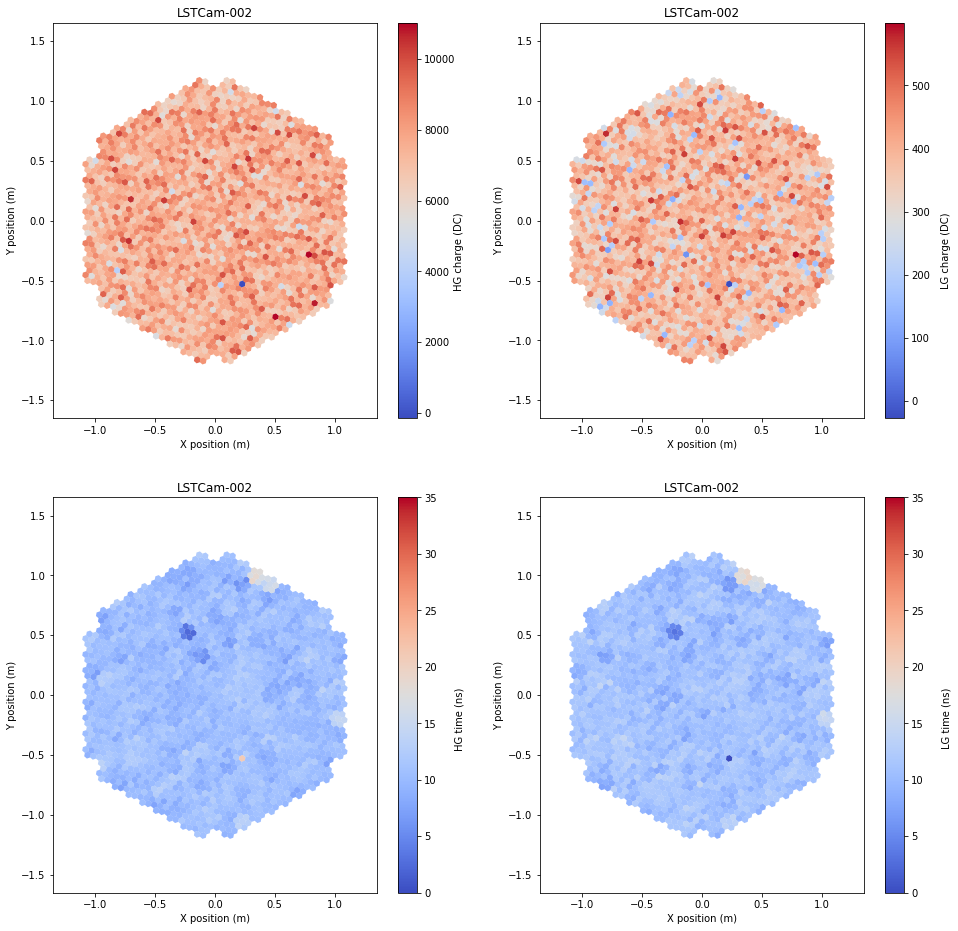

In [7]:
# integrate the charge on 12 ns around the peak value

config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 5,
        "window_width": 11 
    }
})
integrator = LocalPeakWindowSum(config=config)


waveform=event.r1.tel[0].waveform
image, peakpos = integrator(waveform)

fig = plt.figure(figsize=(16, 16))
for chan in(np.arange(2)):
    ax = plt.subplot(2, 2, chan+1)

    disp = CameraDisplay(event.inst.subarray.tels[0].camera)
    disp.image = image[chan]  
    
    #disp.set_limits_minmax(2000,4000)
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f'{channel[chan]} charge (DC)', rotation=90)
    disp.add_colorbar()
   
    ax = plt.subplot(2, 2, chan+3)
    disp = CameraDisplay(event.inst.subarray.tels[0].camera)
    disp.image = peakpos[chan]  
    disp.cmap = plt.cm.coolwarm
    disp.set_limits_minmax(0,35)
    disp.axes.text(2.0, 0, f'{channel[chan]} time (ns)', rotation=90)
    
    disp.add_colorbar()

    disp.update()

#plt.savefig(f"Run{run}_event_{event.lst.tel[0].evt.event_id}_charge_time.png")   

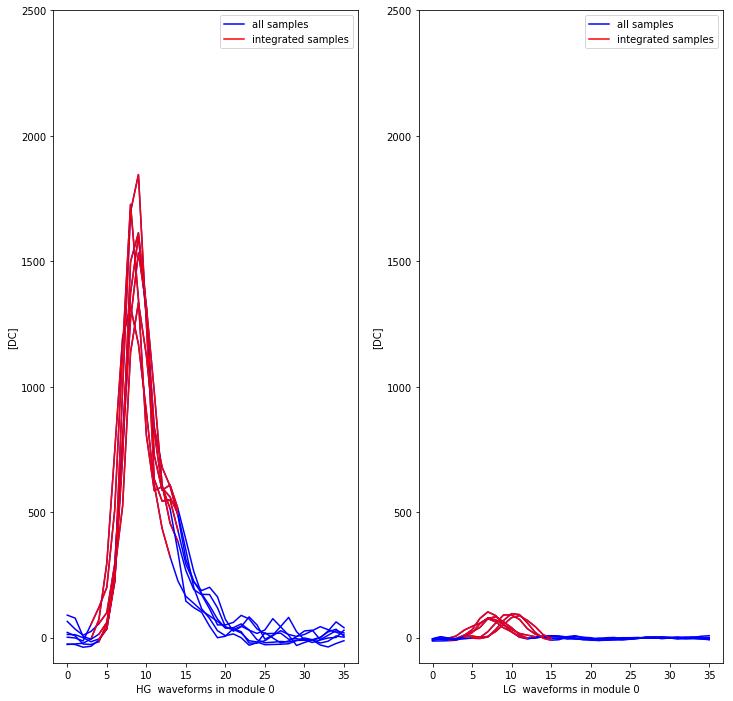

In [9]:
# Plot the part of the waveform that is integrated
# (this work only after the line above)

fig = plt.figure(0,figsize=(12,12))

# consider only 36 samples
samples=np.arange(0,36)

# chose the module


module=0
module_rank=np.where(event.lst.tel[0].svc.module_ids==module)


# find pixel index in module
pix_in_mod=event.lst.tel[0].svc.pixel_ids[module_rank[0][0]*7:module_rank[0][0]*7+7]
 

for chan in(np.arange(2)): 

    plt.subplot(1,2,chan+1)
    
    for i,pix in enumerate(pix_in_mod):
    
        # samples used to calculate the charge
        start=int(peakpos[chan,pix]-integrator.window_shift)
        stop=int(start+integrator.window_width)
        used_samples=np.arange(start,stop)
        used=waveform[chan,pix,start:stop]
        
            
        plt.plot(waveform[chan,pix,], color='b', label='all samples')
        plt.plot(used_samples,used, color='r', label='integrated samples')
        if i==0:
            plt.legend()
        plt.ylabel("[DC]")
        plt.xlabel(f"{channel[chan]}  waveforms in module {module}")
        plt.ylim(-100,2500)
        fig.savefig(f"Run{run}_waverforms_module_{module}.png")



In [10]:
# flat field calculations

from ctapipe.calib.camera.pedestals import PedestalIntegrator
from ctapipe.calib.camera.flatfield import FlasherFlatFieldCalculator


# configuration for the pedestal charge integrator
ped_config = Config({
    "FixedWindowSum": {
        "window_start": 11,
        "window_width": 11,
    }    
})

# configuration for the flatfield charge integrator
ff_config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 4,
        "window_width": 11,
    }    
    
})

ped_calculator = PedestalIntegrator(tel_id=0,
                                    sample_size=100,
                                    charge_median_cut_outliers = [-4,4],
                                    charge_std_cut_outliers = [-4,4],
                                    charge_product="FixedWindowSum",
                                    config=ped_config)



ff_calculator = FlasherFlatFieldCalculator(tel_id = 0,
                                           sample_size=100,
                                           sample_duration = 1000,
                                           charge_cut_outliers = [-0.4,0.4],
                                           time_cut_outliers = [0,30],
                                           charge_product = "LocalPeakWindowSum",
                                           config=ff_config)

calib_event=0
ped_event = False
ped_initialized = False
initialized = False
for i, event in enumerate(reader): 

    
    # create r1 
    r0calib.calibrate(event)    
              
    # get link to monitoring containers
    if not initialized:
        ped_data = event.mon.tel[tel_id].pedestal 
        ff_data = event.mon.tel[tel_id].flatfield
        status_data = event.mon.tel[tel_id].pixel_status
        calib_data = event.mon.tel[tel_id].calibration
    
    # if new pedestal calculation
    if event.lst.tel[0].evt.tib_masked_trigger == 32:    
        if ped_calculator.calculate_pedestals(event):

            ped_event = True
            print(f"new pedestal at event n. {event.r0.event_id} ({i+1})")

    # consider flat field events only after first pedestal event (for pedestal mask initalization)
    elif event.lst.tel[0].evt.tib_masked_trigger == 1 and event.r1.tel[tel_id].waveform.max()>1000:
        
        if ff_calculator.calculate_relative_gain(event):
            calib_event+=1
            print(f"new flatfield at event n. {event.r0.event_id} ({i+1})")  
            
            # consider values only after first flat field event (for flat field mask initialitation)
            if calib_event > 1:
                # mask from pedestal and flat-fleid data
                monitoring_unusable_pixels= np.logical_or(status_data.pedestal_failing_pixels,
                                                          status_data.flatfield_failing_pixels)
                
                # calibration unusable pixels are an OR of all maskes
                calib_data.unusable_pixels = np.logical_or(monitoring_unusable_pixels,status_data.hardware_failing_pixels)
               
    
                # Extract calibraiton coefficients with F-factor method
                # Assume fix F2 factor, F2=1+Var(gain)/Mean(Gain)**2 must be known from elsewhere
                F2 =1.2
                
                # calculate photon-electrons
                pe = F2*(ff_data.charge_median - ped_data.charge_median)**2/(ff_data.charge_std**2 - ped_data.charge_std**2)
               
                
                masked_pe = np.ma.array(pe, mask=calib_data.unusable_pixels)

                break
                


new pedestal at event n. 201 (199)
new flatfield at event n. 202 (200)
new pedestal at event n. 399 (397)
new flatfield at event n. 404 (402)


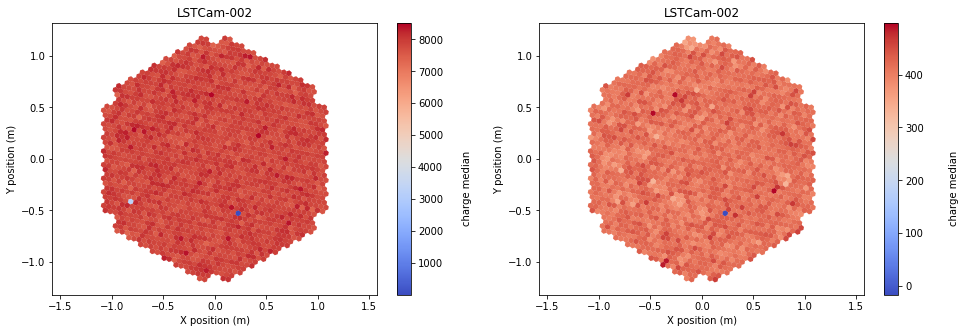

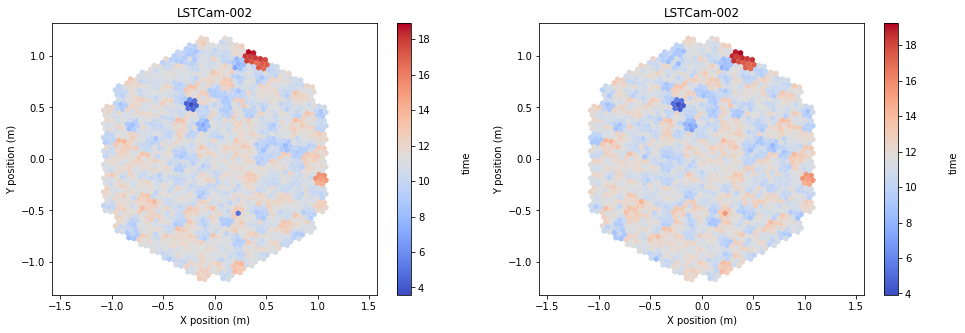

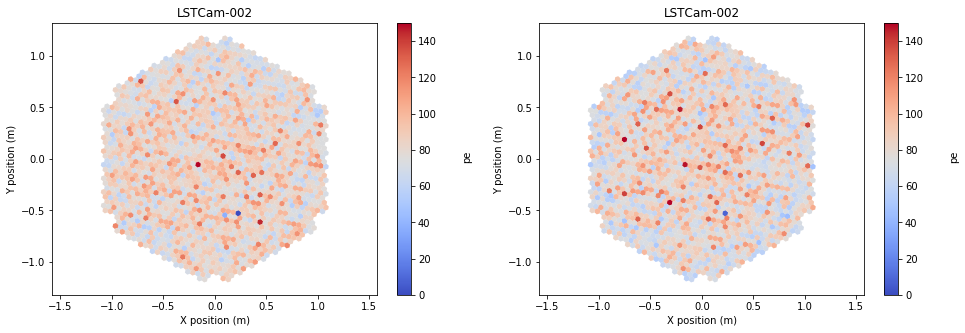

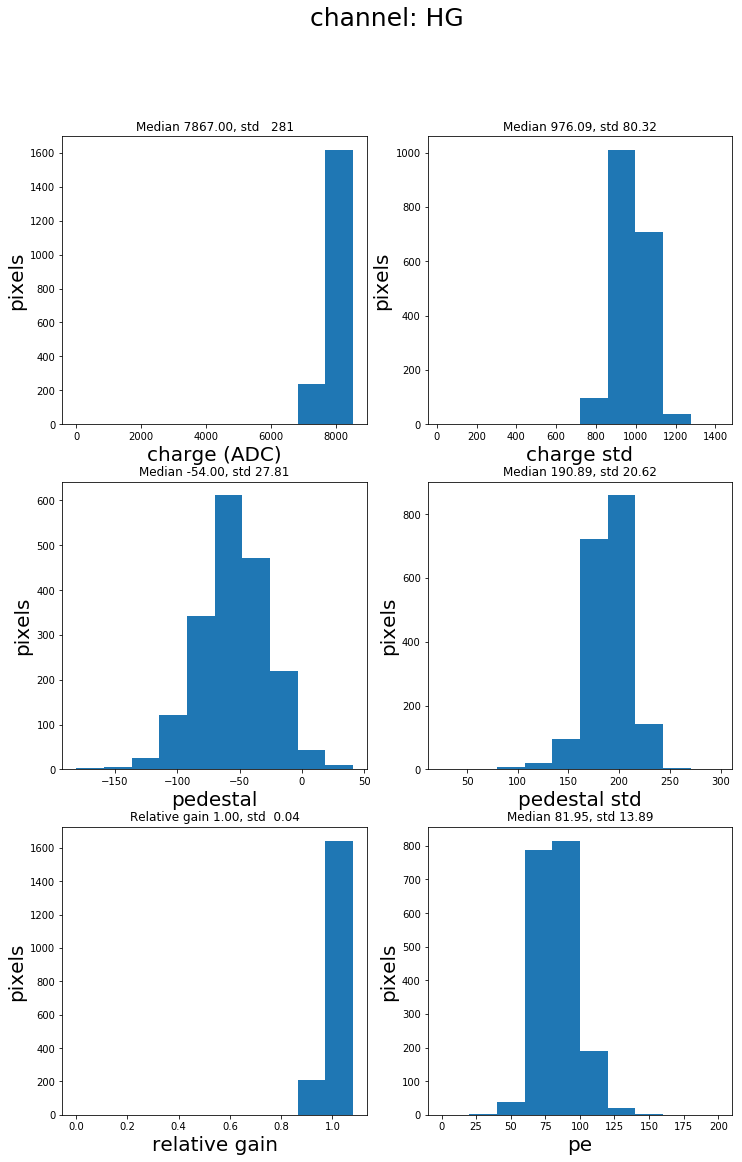

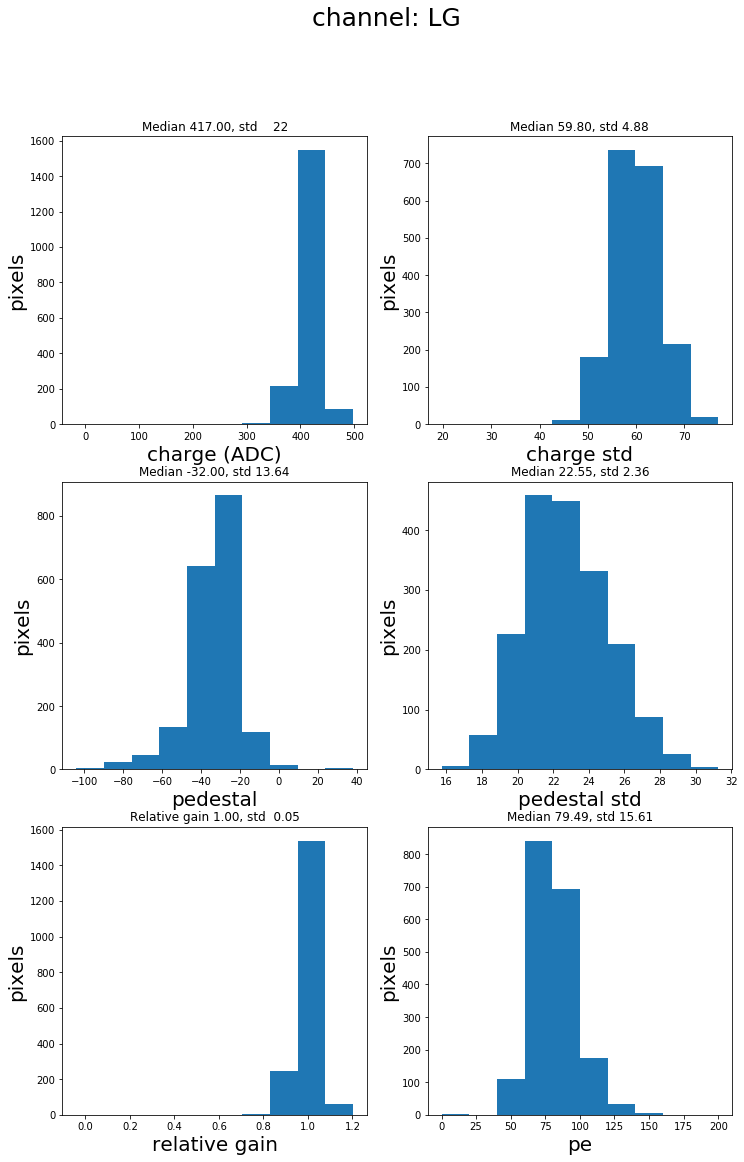

In [11]:
                
# plot results  
mask =  calib_data.unusable_pixels

# charge

fig = plt.figure(10,figsize=(16, 5))
image = ff_data.charge_median
for chan in(np.arange(2)):
    ax = plt.subplot(1, 2, chan+1)
    disp = CameraDisplay(event.inst.subarray.tels[tel_id].camera)
    disp.highlight_pixels(mask[chan])
    disp.image = image[chan]  
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.4, 0, 'charge median', rotation=90)
    disp.add_colorbar() 
    
# time
fig = plt.figure(11,figsize=(16, 5))
image = ff_data.time_median
for chan in(np.arange(2)):
    ax = plt.subplot(1, 2, chan+1)
    disp = CameraDisplay(event.inst.subarray.tels[tel_id].camera)
    disp.highlight_pixels(mask[chan])
    disp.image = image[chan]  
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.4, 0, 'time', rotation=90)
    disp.add_colorbar()    

#pe
fig = plt.figure(12,figsize=(16, 5))
image = pe
for chan in(np.arange(2)):
    ax = plt.subplot(1, 2, chan+1)
    disp = CameraDisplay(event.inst.subarray.tels[tel_id].camera)
    disp.highlight_pixels(mask[chan])
    disp.set_limits_minmax(0,150)
    disp.image = image[chan]  
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.4, 0, 'pe', rotation=90)
    disp.add_colorbar()
    
# plot some histograms    
for chan in np.arange(2):
        n_pe = pe[chan]
        gain_median = ff_data.relative_gain_median[chan]
        charge_median = ff_data.charge_median[chan]
        charge_std = ff_data.charge_std[chan]
        median_ped = ped_data.charge_median[chan]
        ped_std = ped_data.charge_std[chan]
        
        # select good pixels
        select = np.logical_not(mask[chan])
        #select = mask[chan]
                      
        fig = plt.figure(chan,figsize=(12,18))
        fig.suptitle(f"channel: {channel[chan]}", fontsize=25) 
        
        # charge
        plt.subplot(321)
        median= int(np.median(charge_median[select])) 
        rms= np.std(charge_median[select])
        
        plt.title(f"Median {median:3.2f}, std {rms:5.0f}") 
        plt.xlabel('charge (ADC)',fontsize=20)
        plt.ylabel('pixels',fontsize=20) 
        plt.hist(charge_median[select])  

        # signal std
        plt.subplot(322)
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('charge std',fontsize=20) 
        median= np.median(charge_std[select])
        rms= np.std(charge_std[select])
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(charge_std[select])
        
        # pedestal charge
        plt.subplot(323)
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('pedestal',fontsize=20) 
        median= np.median(median_ped[select])
        rms= np.std(median_ped[select])
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(median_ped[select])  
        
        # pedestal std
        plt.subplot(324)
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('pedestal std',fontsize=20) 
        median= np.median(ped_std[select])
        rms= np.std(ped_std[select])
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(ped_std[select])        
        
        # relative gain
        plt.subplot(325)
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('relative gain',fontsize=20)            
        plt.hist(gain_median[select])
        
        median= np.median(gain_median[select]) 
        rms= np.std(gain_median[select])
        plt.title(f"Relative gain {median:3.2f}, std {rms:5.2f}") 
        
        # photon electrons        
        plt.subplot(326) 
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('pe',fontsize=20) 
        median= np.median(n_pe[select])
        rms= np.std(n_pe[select])
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(n_pe[select],range=(0,200))  

In [12]:
# use the tool to write calibration coefficients
from lstchain.tools.calc_camera_calibration import CalibrationHDF5Writer
calibration_tool= CalibrationHDF5Writer()
calibration_tool.print_help()

Generate a HDF5 file with camera calibration coefficients

Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--input_file=<Unicode> (EventSource.input_url)
    Default: ''
    Path to the input file containing events.
--output_file=<Unicode> (CalibrationHDF5Writer.output_file)
    Default: 'calibration.hdf5'
    Name of the output file
--log_file=<Unicode> (CalibrationHDF5Writer.log_file)
    Default: 'None'
    Name of the log file
--max_events=<Int> (EventSource.max_events)
    Default: None
    Maximum number of events that will be read from the file
--pedestal_file=<Unicode> (LSTR0Corrections.pedestal_path)
    Default: ''
    Path to the LST pedestal binary file
--flatfield_product=<CaselessStrEnum> (CalibrationHDF5Writer.flatfield_product)
    Default: 'FlasherFlatFieldCalculator'
    Choices: ['FlasherFlatFieldCalculator', 'F

In [13]:
# 
calibration_tool.run(argv=['--config','/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/camera_calibration_param.json'])

INFO [CalibrationHDF5Writer] (tool/initialize): ctapipe version 0.6.2.post180+git5a1a6d4
INFO [CalibrationHDF5Writer] (tool/run): Starting: CalibrationHDF5Writer
DEBUG [CalibrationHDF5Writer] (calc_camera_calibration/setup): Input file has file 53004 events
INFO [CalibrationHDF5Writer.FlasherFlatFieldCalculator] (flatfield/__init__): extractor <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7fd7463a4128>
INFO [CalibrationHDF5Writer.FlasherFlatFieldCalculator] (flatfield/__init__): Used events statistics : 100
INFO [CalibrationHDF5Writer.PedestalIntegrator] (pedestals/__init__): extractor <ctapipe.image.extractor.FixedWindowSum object at 0x7fd7442c3908>
INFO [CalibrationHDF5Writer.PedestalIntegrator] (pedestals/__init__): Used events statistics : 100
DEBUG [CalibrationHDF5Writer] (calc_camera_calibration/setup): Open output file calibration.hdf5
INFO [CalibrationHDF5Writer] (tool/run): CONFIG: {'CalibrationHDF5Writer': {'config_file': '/astro/users/cassol/soft/python/cta-lstchai

Table '/tel_0/flatfield' is missing column 'charge_std_outliers' that is in container FlatFieldContainer. It will be skipped.
Table '/tel_0/calibration' is missing column 'pedestal_per_sample' that is in container WaveformCalibrationContainer. It will be skipped.


{'sample_time': <Quantity 1.61459295 s>, 'sample_time_range': <Quantity [140.7604873, 143.9896732] s>, 'n_events': 100, 'charge_mean': array([[8750.65, 8023.01, 6412.18, ..., 6019.34, 8470.88, 8905.34],
       [ 463.79,    0.  ,  337.79, ...,    0.  ,  445.92,  461.43]]), 'charge_median': array([[9251.5, 8535. , 6624.5, ..., 6354.5, 8844. , 9329.5],
       [ 491.5,    0. ,  354. , ...,    0. ,  469.5,  483.5]]), 'charge_std': array([[2597.08472859, 2335.80559763, 1917.29261397, ..., 1813.91913943,
        2659.01584155, 2688.28660012],
       [ 143.03358312,    0.        ,  109.52984023, ...,    0.        ,
         148.550172  ,  144.58770729]]), 'time_mean': array([[25.29471524, 25.01204876, 25.68331372, ..., 24.86632861,
        23.4798646 , 24.21229397],
       [25.28042316,  0.        , 26.63137701, ...,  0.        ,
        24.41452561, 24.07448368]]), 'time_median': array([[25.6315467 , 25.55059458, 26.6625068 , ..., 25.61345969,
        24.25807469, 24.7955816 ],
       [25.680

Text(0.5,1,'ADC per photon-electrons, mean=  495 ADC')

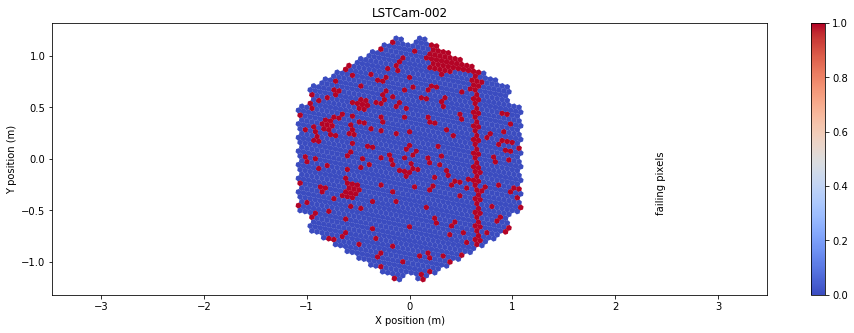

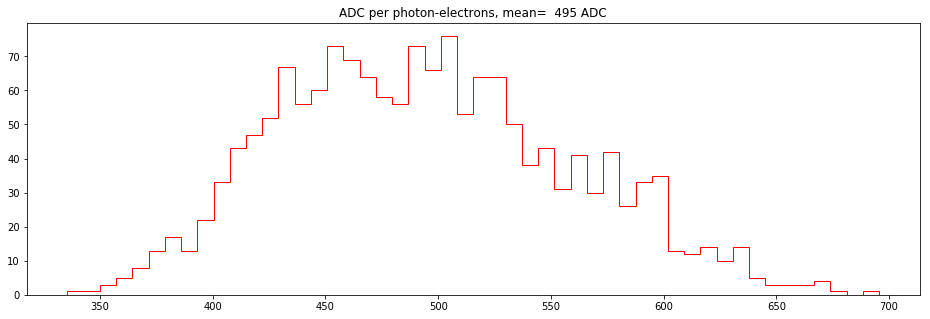

In [14]:
# read back the monitoring containers written with the tool calc_camera_calibration.py
from ctapipe.io.containers import FlatFieldContainer, WaveformCalibrationContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
ff_data = FlatFieldContainer()
cal_data =  WaveformCalibrationContainer()

#with HDF5TableReader('/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/calibration.hdf5') as h5_table:
with HDF5TableReader('/astro/users/cassol/soft/python/lstchain-test/calibration.hdf5') as h5_table:

    assert h5_table._h5file.isopen == True

    for cont in h5_table.read('/tel_0/flatfield', ff_data):
            print(cont.as_dict())
            
    for calib in h5_table.read('/tel_0/calibration', cal_data):
            print(calib.as_dict())
            #plt.hist(1/calib.dc_to_pe[0], color='r', histtype='step', bins = 50, stacked=True, fill=False)
                    
h5_table.close() 

# Perform some plots
fig = plt.figure(13,figsize=(16, 5))
disp = CameraDisplay(event.inst.subarray.tels[0].camera)                                                                             
disp.image = calib.unusable_pixels[chan]
disp.set_limits_minmax(0,1)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'failing pixels', rotation=90)
disp.add_colorbar()

# 
select=np.logical_not(calib.unusable_pixels[0])
values=1/calib.dc_to_pe[0]

fig = plt.figure(12,figsize=(16, 5))
plt.hist(values[select], color='r', histtype='step', bins = 50, stacked=True, fill=False)
plt.title(f"ADC per photon-electrons, mean={np.mean(values[select]):5.0f} ADC") 
